In [1]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms, models

import json
from matplotlib.ticker import FormatStrFormatter
import copy
from collections import OrderedDict

In [2]:
data_dir = 'all_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128




# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])



# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir ,transform = test_transforms)



train_loader = torch.utils.data.DataLoader(
             train_data,
             batch_size=batch_size, shuffle=True,
             num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(valid_data,
             batch_size=batch_size, shuffle=True,
             num_workers=num_workers)


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [4]:
# TODO: Build and train your network

model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad=False

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# move the model to GPU, if available
train_on_gpu = torch.cuda.is_available()    
    
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda() 

In [7]:
# number of epochs to train the model
n_epochs = 10



best_model_weights = copy.deepcopy(model.state_dict())
best_acc = 0.0

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0
    
    ###################
    # train the model #
    ###################
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        
        ps = torch.exp(output).data
        equality = (target.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()
        
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    accuracy = accuracy /len(valid_loader)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \t accuracy:{:.6f}'.format(
        epoch, train_loss, valid_loss,accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        best_acc = accuracy
        best_model_weights = copy.deepcopy(model.state_dict())
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.224734 	Validation Loss: 1.007366 	 accuracy:0.427031
Epoch: 2 	Training Loss: 0.780965 	Validation Loss: 0.603771 	 accuracy:0.652500
Epoch: 3 	Training Loss: 0.610009 	Validation Loss: 0.575012 	 accuracy:0.719375
Epoch: 4 	Training Loss: 0.567159 	Validation Loss: 0.540188 	 accuracy:0.699375
Epoch: 5 	Training Loss: 0.528707 	Validation Loss: 0.498585 	 accuracy:0.738438
Epoch: 6 	Training Loss: 0.477685 	Validation Loss: 0.469679 	 accuracy:0.799375
Epoch: 7 	Training Loss: 0.445611 	Validation Loss: 0.430836 	 accuracy:0.806719
Epoch: 8 	Training Loss: 0.418546 	Validation Loss: 0.416567 	 accuracy:0.818437
Epoch: 9 	Training Loss: 0.410244 	Validation Loss: 0.418120 	 accuracy:0.758906
Epoch: 10 	Training Loss: 0.368434 	Validation Loss: 0.388016 	 accuracy:0.842344


In [8]:
model.load_state_dict(best_model_weights)

<All keys matched successfully>

In [9]:
with torch.no_grad():
    batch_accuracy = []
    
    for idx, (inputs, labels) in enumerate(test_loader):
        
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model.forward(inputs)
        _, predicted = outputs.max(dim=1)
        equals = predicted == labels.data
        #print("Batch accuracy (Size {}): {}".format(batch_size, equals.float().mean()))
        batch_accuracy.append(equals.float().mean().cpu().numpy())
    mean_acc = np.mean(batch_accuracy)
    print("Mean Test accuracy: {}".format(mean_acc))

Mean Test accuracy: 0.833834171295166


In [10]:
# TODO: Save the checkpoint 

model.class_to_idx = train_data.class_to_idx
model.cpu
torch.save({'structure' :'resnet18',
            'input_size': [3, 224, 224],
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx},
            'checkpoint.pth')

In [11]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_model(path):
    checkpoint = torch.load('checkpoint.pth')
    structure = checkpoint['structure']
    model = models.resnet34()
    
    classifier = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))
    
    
    model.fc = classifier
    model.load_state_dict(checkpoint['state_dict'])
    return model, checkpoint['class_to_idx']
    
loaded_model, class_to_idx = load_model('my_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [12]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor
    
    


In [13]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [14]:
def predict(image_path, model, topk=1):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

In [15]:
img = ('./Leaf_data/test/Negative/30-03-2019_15-19-25.jpg')
val1, val2 = predict(img,loaded_model)
print(val1)
print(val2)

tensor([[0.6778]], device='cuda:0')
tensor([[0]], device='cuda:0')


In [16]:
idx_to_class

{0: 'Negative', 1: 'Positive'}

In [17]:
idx_to_class[val2.cpu().numpy()[0][0]]

'Negative'

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
from sklearn.metrics import confusion_matrix

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[73 17]
 [18 46]]
[81.11111111 71.875     ]


In [23]:
from sklearn.metrics import accuracy_score

In [24]:
accuracy_score(lbllist.numpy(), predlist.numpy())

0.7727272727272727

In [20]:
class_names = ['Good Leaf','Bad Leaf']

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):



    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

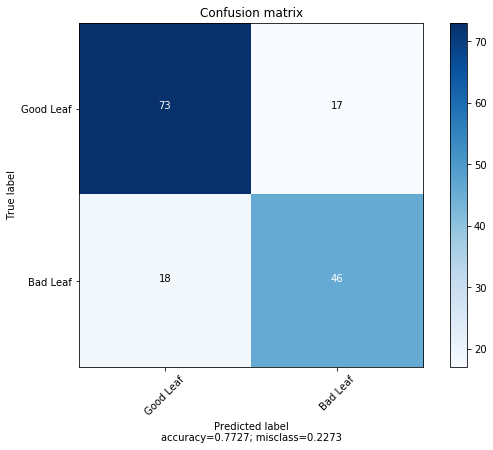

In [22]:
plot_confusion_matrix(cm=conf_mat,target_names=class_names,cmap=plt.cm.Blues)